In [1]:
# set up matplotlib
%matplotlib widget
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams.update({"font.size": 14})

In [2]:
import numpy as np
import xarray as xr
from scipy.special import j0
from scipy.interpolate import RectBivariateSpline
from xbout import open_boutdataset

In [3]:
case = "3" # Case 1 is for anomalous density diffusion only.
filepath = "mms" + str(case) + "/BOUT.dmp.*.nc"
#filepath = "test" + str(case) + "/BOUT.dmp.0.nc"

ds = open_boutdataset(datapath=filepath, chunks={"t": 4})
dsn = xr.open_dataset("circle_midres.fci.nc")

# Use squeeze() to get rid of the y-dimension, which has length 1 usually unless turbulent.
ds = ds.squeeze(drop=True)
dsn = dsn.squeeze(drop=True)

for key,val in ds.items():
    print(key)

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset> Size: 666MB
Dimensions:             (x: 260, y: 1, z: 260, t: 201)
Coordinates:
    dx                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    dy                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    dz                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
  * t                   (t) float64 2kB 0.0 5e+05 1e+06 ... 9.95e+07 1e+08
  * x                   (x) int64 2kB 0 1 2 3 4 5 6 ... 254 255 256 257 258 259
  * y                   (y) float64 8B 0.1963
  * z                   (z) float64 2kB 0.001923 0.005769 ... 0.9942 0.9981
Data variables: (12/52)
    Bxy                 (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    G1                  (x, y, z) float64 541kB dask.array<chunksize=(260, 1, 260), meta=np.ndarray>
    G2                  (x, y, z) float64 541kB dask.array

/home/tirkas1/miniconda3/lib/python3.13/site-packages/xbout/load.py:341: UserWarning: No geometry type found, no physical coordinates will be added
  warn("No geometry type found, no physical coordinates will be added")


In [4]:
dx = ds["dx"].isel(z=0).values

# Get rid of existing "x" coordinate, which is just the index values.
#ds = ds.drop("x")

# Create a new coordinate, which is length in units of rho_s
ds = ds.assign_coords(x=np.arange(ds.sizes["x"])*dx)

#Store just initial values as well.
ds_initial = ds.isel(t=0)

In [5]:
dens = ds["Nh+"][:,2:-2,:]
dens_true = dens.copy()

mask = dsn["in_mask"][2:-2,:]
ghost_id = dsn["ghost_id"].values
gst_pts = dsn["ghost_pts"].values
bdy_pts = dsn["bndry_pts"].values
img_pts = dsn["image_pts"].values
normals = dsn["normals"].values
is_plasma = dsn["is_plasma"].values
Rarr = dsn["R"].values[2:-2,:]
Zarr = dsn["Z"].values

timestep_for_errs_early = 10
timestep_for_errs_late = 100
spl_e = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_early,:,:], kx=1, ky=1)
spl_l = RectBivariateSpline(Rarr[:,0], Zarr[0,:], dens.values[timestep_for_errs_late,:,:], kx=1, ky=1)

In [6]:
alpha0 = 2.404825557693792
xc, zc = 1.5, 0.0

x_unit = 0.00022846974366979959 #rho_s0
w_unit = 95788333.030660808    #Omega_ci
t_unit = 1/w_unit

nx = 64*4 #int(case)
nz = nx + 4
dx = np.float64(1.0) / np.float64(nx)
dz = np.float64(1.0) / np.float64(nz)

# Centers in x; faces/nodes in z if that's your convention
x = (np.arange(nx, dtype=np.float64) + 0.5) * dx     # centered x
z = (np.arange(nz, dtype=np.float64)) * dz           # unshifted z

xhalf  = np.float64(x[len(x)//2])
zhalf  = np.float64(z[len(z)//2])

xx, zz = np.meshgrid(x,z,indexing='ij',copy=False)
a      = np.float64(0.333333333333333)
D      = np.float64(0.2)#/(x_unit*x_unit*w_unit)
t64 = np.asarray(ds["t_array"].values, dtype=np.float64) # 1D time
t_norm = t64*t_unit
#spatial = ((xx - xhalf)**2 + (zz-zhalf)**2)
spatial = j0(alpha0*np.hypot(xx - xhalf, zz - zhalf)/a)
#temp = 4.0*D*t_norm #t64/t64[-1]
a_norm = a/x_unit
temp = np.exp(-D * (alpha0 / a)**2 * (t_norm))

#dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:] + np.asarray(temp)[:,np.newaxis,np.newaxis]
dens_true[:,:,:] = np.asarray(spatial)[np.newaxis,:,:]*np.asarray(temp)[:,np.newaxis,np.newaxis]

bdy_pts_xz_e = spl_e.ev(bdy_pts[:,0], bdy_pts[:,1])
bdy_pts_xz_l = spl_l.ev(bdy_pts[:,0], bdy_pts[:,1])
print("Linf bdy err if dirichlet: " + str(np.max(np.abs(bdy_pts_xz_e))))
print("L2 bdy err (early) if dirichlet?: "  + str(np.mean(np.abs(bdy_pts_xz_e))))
print("L2 bdy err (late) if dirichlet?: "  + str(np.mean(np.abs(bdy_pts_xz_l))))

#dndR = spl.ev(bdy_pts[:,0], bdy_pts[:,1], dx=1, dy=0) # ∂n/∂R at boundary points
#dndZ = spl.ev(bdy_pts[:,0], bdy_pts[:,1], dx=0, dy=1) # ∂n/∂Z at boundary points
#dn_dn = dndR * normals[:,0] + dndZ * normals[:,1]     # normal derivative
dP = np.einsum('ij,ij->i', (bdy_pts - img_pts), -normals)
dG = np.einsum('ij,ij->i', (gst_pts - bdy_pts), -normals)
dn_dn_e = (spl_e.ev(img_pts[:,0], img_pts[:,1]) - spl_e.ev(gst_pts[:,0], gst_pts[:,1])) / (dP + dG)
dn_dn_l = (spl_l.ev(img_pts[:,0], img_pts[:,1]) - spl_l.ev(gst_pts[:,0], gst_pts[:,1])) / (dP + dG)

Linf = np.max(np.abs(dn_dn_e))
L2   = np.sqrt(np.mean(dn_dn_e**2))
L2   = np.sqrt(np.mean(dn_dn_l**2))
print("Linf bdy err if neumann: " + str(np.max(np.abs(dn_dn_e))))
print("L2 bdy err (early) if neumann: " + str(np.sqrt(np.mean(dn_dn_e**2))))
print("L2 bdy err (late) if neumann: " + str(np.sqrt(np.mean(dn_dn_l**2))))

Linf bdy err if dirichlet: 3.654037131207754e-05
L2 bdy err (early) if dirichlet?: 1.1808820371061628e-05
L2 bdy err (late) if dirichlet?: 8.878327002678913e-08
Linf bdy err if neumann: 2.1904149941772793
L2 bdy err (early) if neumann: 2.179480280392128
L2 bdy err (late) if neumann: 0.01638609950883742


In [7]:
img_pts_xz = spl_e.ev(img_pts[:,0], img_pts[:,1])

i = 0
for idx in range(nx+4):
    for idz in range(nz):
        gid = int(ghost_id[idx,idz])
        if gid >= 0:
            print(gid)
            if (not (is_plasma[gid,0] and is_plasma[gid,1] and is_plasma[gid,2] and is_plasma[gid,3])):
               print("Contains multiple ghost cell corners.")
            print(img_pts[gid])
            print(img_pts_xz[gid])

0
[ 1.17206155 -0.03003092]
0.008770028275935211
1
[ 1.17141416 -0.02633541]
0.008040787484503195
2
[ 1.17085087 -0.02261804]
0.007412838017771871
3
[ 1.17037242 -0.01888196]
0.006882669767244771
4
[ 1.16997945 -0.01513032]
0.0064487728163769836
5
[ 1.16967245 -0.0113663 ]
0.006110425071336277
6
[ 1.16945182 -0.00759309]
0.005867418610435384
7
[ 1.16931784 -0.00381391]
0.005719616322265577
8
[1.16927083e+00 8.16431199e-17]
0.005666545382792292
9
[1.16931784 0.00381391]
0.0057196163222650925
10
[1.16945182 0.00759309]
0.005867418610434814
11
[1.16967245 0.0113663 ]
0.006110425071336361
12
[1.16997945 0.01513032]
0.00644877281637852
13
[1.17037242 0.01888196]
0.006882669767246662
14
[1.17085087 0.02261804]
0.0074128380177726876
15
[1.17141416 0.02633541]
0.008040787484502002
16
[1.17206155 0.03003092]
0.008770028275933338
17
[ 1.17653928 -0.0599971 ]
0.009510534977293147
18
[ 1.17519921 -0.05639195]
0.008003649900704053
19
[ 1.17396154 -0.05284415]
0.006616789880435045
20
[ 1.17280172 -0

Dirichlet Linf int err: 1.568628087611082e-05
Dirichlet L2 int err (early): 1.3365917663251269e-05
Dirichlet L2 int err (late): 1.7409702413899666e-07
Neumann Linf int err: 1.273164551558087e-05
Neumann L2 int err (early): 1.0016913083170957e-05
Neumann L2 int err (late): 2.1327997399807376e-08


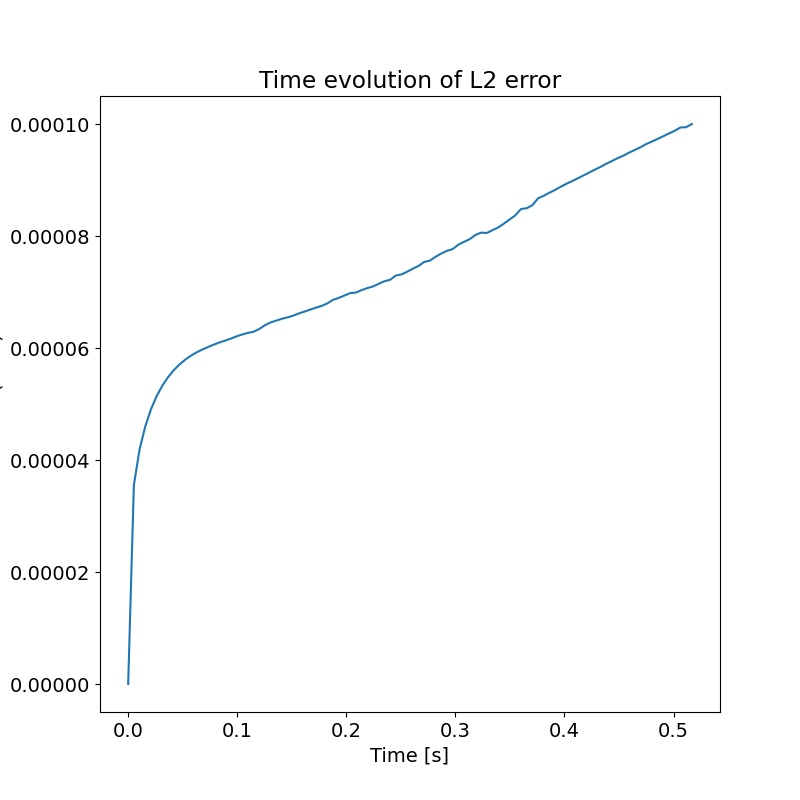

In [8]:

dens0 = dens.where(mask) - np.nanmean(dens.where(mask), axis=(1,2), keepdims=True)
true0 = dens_true.where(mask) - np.nanmean(dens_true.where(mask), axis=(1,2), keepdims=True)
dens_diff0 = dens0 - true0
dens_diff = dens.where(mask) - dens_true.where(mask)

l2_err_t = np.sqrt(np.nanmean(dens_diff**2, axis=(1, 2)))
l2_err_n_t = np.sqrt(np.nanmean(dens_diff0**2, axis=(1, 2)))
l2_relerr_t = l2_err_t/np.sqrt(np.nanmean(dens_true**2, axis=(1,2)))
l2_relerr_n_t = l2_err_n_t/np.sqrt(np.nanmean(true0**2, axis=(1,2)))


print("Dirichlet Linf int err: " + str(np.max(l2_err_t)))
print("Dirichlet L2 int err (early): "   + str(l2_err_t[timestep_for_errs_early]))
print("Dirichlet L2 int err (late): "   + str(l2_err_t[timestep_for_errs_late]))

print("Neumann Linf int err: " + str(np.max(l2_err_n_t)))
print("Neumann L2 int err (early): "   + str(l2_err_n_t[timestep_for_errs_early]))
print("Neumann L2 int err (late): "   + str(l2_err_n_t[timestep_for_errs_late]))

#l2_err = np.sqrt(np.nanmean(dens_diff[100,:,:]**2))
#l2_unnorm = np.sqrt(np.nansum(dens_diff[100,:,:]**2)*dx*dz)
#l2_rel = np.sqrt(np.nansum(dens_diff[100,:,:]**2)*dx*dz) / np.sqrt(np.nansum(dens_true[100,:,:]**2)*dx*dz)
#print("L2 (RMS): "    + str(l2_err))
#print("L2 (unnorm): " + str(l2_unnorm))
#print("L2 (rel): "    + str(l2_rel))
#
#true = dens_true.values[1:10, len(x)//2, len(z)//2] - dens_true.values[0, len(x)//2, len(z)//2]
#sim = dens.values[1:10, len(x)//2, len(z)//2] - dens.values[0, len(x)//2, len(z)//2]
##print(*np.abs(sim-true), sep="\n")
#
#init_dens_diff = dens_diff[0,:,:]
#mask2 = init_dens_diff.notnull() & (init_dens_diff >= 1e-10)
#nerrs = int(mask2.sum().compute())
#
#ii, jj = np.where(mask2)
#
#if nerrs > 0:
#    print(init_dens_diff.values[ii[0],jj[0]])
#    print(dens.values[0,ii[0],jj[0]])
#    print(dens_true.values[0,ii[0],jj[0]])
#
#print(nerrs)

plt.plot(t_norm[0:100], l2_relerr_t[0:100])
plt.xlabel("Time [s]")
plt.ylabel("L2 error (RMS)")
plt.title("Time evolution of L2 error")
plt.show()


Observed orders (p) between refinements:
  Boundary L2 (early) : p12=2.155, p23=1.838, avg=1.996
  Boundary L2 (half)  : p12=2.156, p23=1.838, avg=1.997
  Interior L2 (early) : p12=2.027, p23=1.355, avg=1.691
  Interior L2 (half)  : p12=2.028, p23=1.713, avg=1.870
  Boundary L∞         : p12=1.794, p23=1.876, avg=1.835
  Interior L∞         : p12=2.051, p23=1.349, avg=1.700


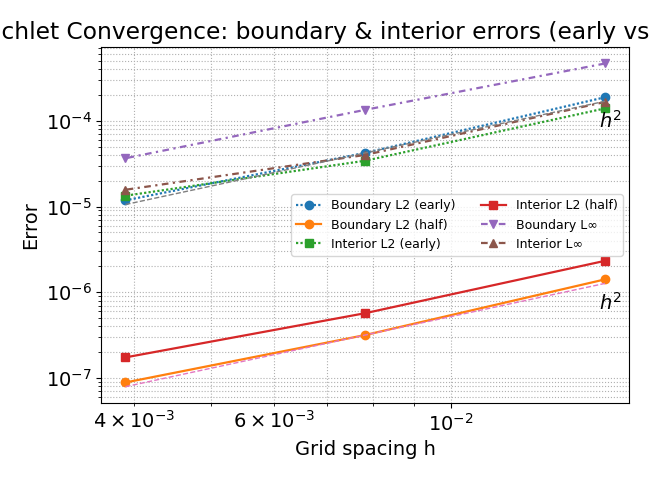

In [9]:
# convegence_plot.py
# Usage: fill in the error arrays below and run:  python convergence_plot.py

import numpy as np
import matplotlib.pyplot as plt

# --- Grid spacings (you can scale by your base h0 if you want) ---
h0 = 1/64               # set to your base h if you care about absolute values
h = np.array([h0, h0/2, h0/4], dtype=float)

# ========================= FILL THESE IN =========================
# L2 @ EARLY time (transients present)
# t=10 fairly transient-y
E_b_L2_early = np.array([0.00018794847005539967, 4.220876730234053e-05, 1.1808820371061628e-05])
E_i_L2_early = np.array([0.00013937400028649028, 3.419268380223026e-05, 1.3365917663251269e-05])

# L2 @ HALF simulation time (transients gone, your current metric)
E_b_L2_half  = np.array([1.4142294831252542e-06, 3.174179626824589e-07, 8.878327002678913e-08])
E_i_L2_half  = np.array([2.3274654189311775e-06, 5.707397281298358e-07, 1.7409702413899666e-07])

# L∞ (single time of your choice—keep as what you were using before)
E_b_Linf     = np.array([0.0004653370920620337, 0.0001341446755724785, 3.654037131207754e-05])
E_i_Linf     = np.array([0.0001656389174821925, 3.996152133707245e-05, 1.568628087611082e-05])
# =================================================================

series = {
    # L2 (two times)
    "Boundary L2 (early)" : E_b_L2_early,
    "Boundary L2 (half)"  : E_b_L2_half,
    "Interior L2 (early)" : E_i_L2_early,
    "Interior L2 (half)"  : E_i_L2_half,
    # L∞
    "Boundary L∞"         : E_b_Linf,
    "Interior L∞"         : E_i_Linf,
}

def observed_order(h, e):
    return np.log(e[:-1]/e[1:]) / np.log(h[:-1]/h[1:])  # p between levels


def add_ref_slope(ax, x_anchor, y_anchor, p, xspan, where="right", offset=(-4, -6)):
    """
    Draw a dashed reference line of slope p through (x_anchor, y_anchor)
    over xspan=(xmin, xmax) on log-log axes, and label it near one end.

    where: "left", "right", or "center"
    offset: (dx, dy) text offset in screen points from the chosen anchor
    """
    x_ref = np.array(xspan, dtype=float)
    y_ref = y_anchor * (x_ref / x_anchor)**p
    ax.loglog(x_ref, y_ref, linestyle='--', linewidth=1.0)

    if where == "left":
        xlab = min(xspan)
    elif where == "right":
        xlab = max(xspan)
    else:  # center (geometric)
        xlab = np.sqrt(xspan[0] * xspan[1])

    ylab = y_anchor * (xlab / x_anchor)**p

    # Nice MathText label; change to f"h^{p:g}" if you prefer plain text
    label = rf"$h^{{{p:g}}}$"

    ax.annotate(
        label,
        xy=(xlab, ylab),
        xytext=offset, textcoords="offset points",
        ha="right" if where == "left" else ("left" if where == "right" else "center"),
        va="top"
    )

# --- Print observed orders ---
print("Observed orders (p) between refinements:")
for name, e in series.items():
    p = observed_order(h, e)
    print(f"  {name:20s}: p12={p[0]:.3f}, p23={p[1]:.3f}, avg={p.mean():.3f}")

# --- Plot ---
fig, ax = plt.subplots(figsize=(6.5, 4.8))

# Use distinct linestyles for time separation on L2 series
linestyles = {
    "Boundary L2 (early)": (0, (1, 1)),
    "Boundary L2 (half)" : "-",
    "Interior L2 (early)": (0, (1, 1)),
    "Interior L2 (half)" : "-",
    "Boundary L∞"        : (0, (3, 2, 1, 2)),
    "Interior L∞"        : (0, (3, 2, 1, 2)),
}

markers = {
    "Boundary L2 (early)": "o",
    "Boundary L2 (half)" : "o",
    "Interior L2 (early)": "s",
    "Interior L2 (half)" : "s",
    "Boundary L∞"        : "v",
    "Interior L∞"        : "^",
}

for name, e in series.items():
    ax.loglog(h, e, marker=markers[name], linewidth=1.6,
              linestyle=linestyles[name], label=name)

ax.set_xlabel("Grid spacing h")
ax.set_ylabel("Error")
ax.set_title("Dirichlet Convergence: boundary & interior errors (early vs half-time)")
ax.grid(True, which='both', ls=':')

# Optional: reference slopes (set to your expected rates)
# Example shows p=2 as a general reference drawn near midpoints of the L2(half) curves
ref_p = 2.0
x_anchor = h[1]
y_anchor = E_b_L2_half[1]
add_ref_slope(ax, x_anchor, y_anchor, ref_p, (h[-1], h[0]))

ref_p = 2.0
x_anchor = h[1]
y_anchor = E_b_L2_early[1]
add_ref_slope(ax, x_anchor, y_anchor, ref_p, (h[-1], h[0]))

ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
dens_diff.bout.animate2D(aspect='equal')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# dens: shape (nt, nx, nz)
# time: shape (nt,)
# dx, dz: scalar cell sizes (uniform grid)
# If nonuniform, use cell area weights instead of dx*dz.

area = dx * dz
# Remove spatial mean at each time step
#dens_meanfree = dens.where(mask) - np.nanmean(dens.where(mask), axis=(1, 2))[:, None, None]

# Compute L2 amplitude (norm of mean-free component)
amp = np.sqrt(np.nansum(dens**2, axis=(1, 2)) * area)

# Take the natural log of amplitude
logA = np.log(amp)

# Choose a time window where the decay is clean (exclude t=0 if noisy)
t_fit = t_norm[5:]       # skip a few early points if needed
logA_fit = logA[5:]

# Linear fit: log(A) = a + b * t
coeffs = np.polyfit(t_fit, logA_fit, 1)
slope, intercept = coeffs[0], coeffs[1]

print(f"Measured slope = {slope:.6e}  (expected -D*alpha1^2)")

# Example for first root of J1
from scipy.special import jn_zeros
alpha1 = jn_zeros(0, 1)[0]  # ~3.8317 for J1's first root

expected_slope = -D * alpha1**2/a**2
print(f"Expected slope = {expected_slope:.6e}")
print(f"Ratio (measured/expected) = {slope / expected_slope:.3f}")

plt.figure(figsize=(6,4))
plt.plot(t_fit, logA_fit, 'o-', label='log(L2 amplitude)')
plt.plot(t_fit, intercept + slope*t_fit, 'r--', label=f'Fit slope = {slope:.3e}')
plt.plot(t_fit, np.log(amp[0]) + expected_slope*t_fit, 'k:', 
         label=f'Expected slope = {expected_slope:.3e}')
plt.xlabel('Time')
plt.ylabel('log(L2 amplitude)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
res_true = (D/(x_unit*x_unit*w_unit))*(alpha0**2/(a/x_unit)**2)*dens_true.where(mask)[0,:,:]
res_sim = ds["SNh+"][0,2:-2,:].where(mask)

res = res_sim + res_true

res_L2 = np.sqrt(np.nansum((res**2)) * dx*dz)
print("||res||_L2 =", float(res_L2)) #, "   relative =", float(rel_res))

In [ ]:
import numpy as np

# Inputs:
# uh, uex: arrays (time, nx, nz) or (nx, nz)
# mask: boolean (nx, nz) == True inside domain
# dx, dz: scalars; area per cell
area = dx*dz
h = min(dx, dz)

# --- simple binary erosion by 1 cell (4-neighborhood) ---
def erode1(m):
    return (m &
            np.roll(m,  1, 0) & np.roll(m, -1, 0) &
            np.roll(m,  1, 1) & np.roll(m, -1, 1))

def erode(m, k):
    out = m.copy()
    for _ in range(k):
        out = erode1(out)
    return out

# choose physical thickness delta = c*h0; set c=2 or 3
c = 2.0
k = max(1, int(np.ceil(c * h / h)))  # simplifies to int(c); keep form for clarity
mask_bool = mask > 0.5
mask_int = erode(mask_bool, k)            # interior region
mask_bnd = mask_bool & ~mask_int          # boundary band (k cells thick)

# error field at time index it
def l2_on(m, e):
    return np.sqrt(np.sum((e**2) * m) * area)

def l2_split(uh, uex, it):
    e = (uh[it] - uex[it])
    L2_full = l2_on(mask_bool, e)
    L2_int  = l2_on(mask_int, e)
    L2_bnd  = l2_on(mask_bnd, e)
    return L2_full, L2_int, L2_bnd

# example:
L2_full, L2_int, L2_bnd = l2_split(dens0.values, true0.values, it=10)
print(L2_full, L2_int, L2_bnd, L2_bnd/L2_full)


In [ ]:
print(dens.values[0,len(x)//2, len(z)//2])
print(dens.values[1,len(x)//2, len(z)//2])
print(dens_true.values[1,len(x)//2, len(z)//2])
print((dens - dens_true).values[1,len(x)//2,len(z)//2])